# 📱 TuniTech Advisor - Exploratory Data Analysis (EDA)

**Authors:** Iheb Lamouchi & Yassine Nemri  
**Date:** February 2026  
**Week 1:** Setup, Scraping & EDA

---

## Objective

This notebook performs comprehensive exploratory data analysis on smartphone data scraped from 4 Tunisian e-commerce websites:
- **Tunisianet** (357 products)
- **SpaceNet** (320 products)
- **Mytek** (281 products)
- **BestPhone** (138 products)

**Total: 1,096 smartphone listings**

## 1. Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 2. Load Datasets

In [19]:
# Path to dataset folder
data_path = Path('../dataset')

# Load all datasets
datasets = {}

# Tunisianet
df_tunisianet = pd.read_csv(data_path / 'tunisianet_smartphones_filled.csv')
df_tunisianet['source'] = 'Tunisianet'
datasets['Tunisianet'] = df_tunisianet

# Mytek
df_mytek = pd.read_csv(data_path / 'mytek_smartphones_filled.csv')
df_mytek['source'] = 'Mytek'
datasets['Mytek'] = df_mytek

# SpaceNet
df_spacenet = pd.read_csv(data_path / 'spacenet_smartphones_filled.csv')
df_spacenet['source'] = 'SpaceNet'
datasets['SpaceNet'] = df_spacenet

# BestPhone
df_bestphone = pd.read_csv(data_path / 'bestphone_smartphones_filled.csv')
df_bestphone['source'] = 'BestPhone'
datasets['BestPhone'] = df_bestphone

# Display counts
print('📦 DATASETS LOADED:')
print('=' * 40)
total = 0
for name, df in datasets.items():
    print(f'  {name}: {len(df)} products')
    total += len(df)
print('=' * 40)
print(f'  TOTAL: {total} products')

📦 DATASETS LOADED:
  Tunisianet: 357 products
  Mytek: 281 products
  SpaceNet: 320 products
  BestPhone: 138 products
  TOTAL: 1096 products


## 3. Create Unified Dataset

We merge all datasets into one unified dataset while keeping the `source` column to track which store each product comes from. This allows us to:
- Compare prices across stores for the same phone
- Show users where to buy a recommended phone

In [ ]:
# Define common columns
common_columns = [
    'name', 'brand', 'ram_gb', 'storage_gb', 'battery_mah', 
    'screen_inches', 'camera_rear_mp', 'camera_front_mp',
    'network', 'os', 'processor_type', 'price', 'source', 'url'
]

def clean_price(price_series, source_name=''):
    """Clean price values: remove non-breaking spaces and convert to numeric."""
    # Convert to string, remove non-breaking space (\xa0) and regular spaces
    cleaned = price_series.astype(str).str.replace('\xa0', '', regex=False)
    cleaned = cleaned.str.replace(' ', '', regex=False)
    # Remove trailing .000 if it exists (e.g., '159.000' -> '159')
    cleaned = cleaned.str.replace(r'\.000$', '', regex=True)
    # Convert to numeric
    numeric_prices = pd.to_numeric(cleaned, errors='coerce')
    
    # Special handling for BestPhone: prices < 10 are in thousands (e.g., 2.2 = 2200 TND)
    if source_name == 'BestPhone':
        # If price is less than 10, it's in thousands format
        numeric_prices = numeric_prices.apply(
            lambda x: x * 1000 if pd.notna(x) and x < 10 else x
        )
    
    return numeric_prices

def standardize_dataframe(df, source_name):
    """Standardize column names and structure."""
    result = pd.DataFrame()
    
    # Name - handle different column names
    result['name'] = df.get('name', df.get('model', ''))
    result['brand'] = df.get('brand', '')
    
    # Specifications
    result['ram_gb'] = df.get('ram_gb', '')
    result['storage_gb'] = df.get('storage_gb', '')
    result['battery_mah'] = df.get('battery_mah', '')
    result['screen_inches'] = df.get('screen_inches', '')
    result['camera_rear_mp'] = df.get('camera_rear_mp', '')
    result['camera_front_mp'] = df.get('camera_front_mp', '')
    result['network'] = df.get('network', '')
    result['os'] = df.get('os', '')
    result['processor_type'] = df.get('processor_type', '')
    
    # Price - handle different column names and clean the values
    if 'price_dt' in df.columns:
        result['price'] = clean_price(df['price_dt'], source_name)
    elif 'price_tnd' in df.columns:
        result['price'] = clean_price(df['price_tnd'], source_name)
    elif 'price' in df.columns:
        result['price'] = clean_price(df['price'], source_name)
    else:
        result['price'] = np.nan
    
    # URL and source
    result['url'] = df.get('url', df.get('product_url', ''))
    result['source'] = source_name
    
    return result

# Combine all datasets
unified_dfs = []
for source_name, df in datasets.items():
    std_df = standardize_dataframe(df, source_name)
    unified_dfs.append(std_df)
    print(f'✓ Standardized {source_name}: {len(std_df)} rows')

# Concatenate
df = pd.concat(unified_dfs, ignore_index=True)
print(f'\n📊 UNIFIED DATASET: {len(df)} total products')

# Show price range
valid_prices = df[df['price'].notna() & (df['price'] > 0)]['price']
print(f'💰 Price range: {valid_prices.min():.0f} - {valid_prices.max():.0f} TND')

# Show price range per source
print('\n💰 Price range by source:')
for source in df['source'].unique():
    source_prices = df[(df['source'] == source) & (df['price'].notna()) & (df['price'] > 0)]['price']
    if len(source_prices) > 0:
        print(f'  {source}: {source_prices.min():.0f} - {source_prices.max():.0f} TND')

# Save
df.to_csv(data_path / 'unified_smartphones.csv', index=False, encoding='utf-8-sig')
print(f'\n💾 Saved to dataset/unified_smartphones.csv')

✓ Standardized Tunisianet: 357 rows
✓ Standardized Mytek: 281 rows
✓ Standardized SpaceNet: 320 rows
✓ Standardized BestPhone: 138 rows

📊 UNIFIED DATASET: 1096 total products
💰 Price range: 1 - 8899 TND
💾 Saved to dataset/unified_smartphones.csv


In [21]:
# Display sample
print('📋 SAMPLE DATA:')
df.head(10)

📋 SAMPLE DATA:


,name,brand,ram_gb,storage_gb,battery_mah,screen_inches,camera_rear_mp,camera_front_mp,network,os,processor_type,price,url,source
0,Smartphone Lesia Young 1 | 2Go / 16Go | Vert,Lesia,4.0,16.0,2500.0,5.0,5.0,2.0,4G,NaN,Quad Core,159.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
1,Smartphone Lesia Young 1 | 2Go / 16Go | Bleu,Lesia,4.0,16.0,2500.0,5.0,5.0,2.0,4G,NaN,Quad Core,159.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
2,Smartphone Lesia Young 6 4Go /16Go - Noir,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
3,Smartphone Lesia Young 6 4Go /16Go - Silver,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
4,Smartphone Lesia Young 6 4Go /16Go - Gold,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
5,Smartphone Lesia Young 2 4Go 32Go -BLEU NUIT,Lesia,4.0,32.0,5000.0,56.0,8.0,5.0,4G,NaN,Octa Core,199.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
6,Smartphone Lesia Young 2 4Go 32Go -VIOLET,Lesia,4.0,32.0,5000.0,56.0,8.0,5.0,4G,NaN,Octa Core,199.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
7,Smartphone Lesia Young 2 4Go 32Go -Vert,Lesia,4.0,32.0,5000.0,56.0,8.0,5.0,4G,NaN,Octa Core,199.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
8,Smartphone Lesia Young 3 2+2Go 32Go -ROSE,Lesia,4.0,32.0,5000.0,56.0,8.0,5.0,4G,Android 13,Octa Core,209.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
9,Smartphone Lesia Young 3 2+2Go 32Go -BLEU NUIT,Lesia,4.0,32.0,5000.0,56.0,8.0,5.0,4G,Android 13,Octa Core,209.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet


## 4. Data Cleaning

In [22]:
# Convert numeric columns
numeric_cols = ['ram_gb', 'storage_gb', 'battery_mah', 'screen_inches', 
                'camera_rear_mp', 'camera_front_mp', 'price']

print('🔧 CONVERTING NUMERIC COLUMNS:')
print('=' * 50)

for col in numeric_cols:
    # Replace empty strings with NaN
    df[col] = df[col].replace(['', 'nan', 'None', 'NaN'], np.nan)
    # Convert to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
    valid_count = df[col].notna().sum()
    pct = valid_count / len(df) * 100
    status = '✓' if pct >= 80 else '⚠️' if pct >= 50 else '❌'
    print(f'  {status} {col}: {valid_count}/{len(df)} valid ({pct:.1f}%)')

# Clean brand names
df['brand'] = df['brand'].str.strip().str.title()
df['brand'] = df['brand'].replace({'Redmi': 'Xiaomi', 'Poco': 'Xiaomi', '': 'Unknown'})

print('\n✅ Data cleaning completed!')

🔧 CONVERTING NUMERIC COLUMNS:
  ✓ ram_gb: 975/1096 valid (89.0%)
  ✓ storage_gb: 1063/1096 valid (97.0%)
  ✓ battery_mah: 985/1096 valid (89.9%)
  ⚠️ screen_inches: 617/1096 valid (56.3%)
  ⚠️ camera_rear_mp: 720/1096 valid (65.7%)
  ⚠️ camera_front_mp: 603/1096 valid (55.0%)
  ✓ price: 953/1096 valid (87.0%)

✅ Data cleaning completed!


## 5. Dataset Overview

In [23]:
print('📊 GENERAL STATISTICS')
print('=' * 40)
print(f'  Total products: {len(df)}')
print(f'  Unique brands: {df["brand"].nunique()}')
print(f'  Data sources: {df["source"].nunique()}')
print(f'  Columns: {len(df.columns)}')

📊 GENERAL STATISTICS
  Total products: 1096
  Unique brands: 20
  Data sources: 4
  Columns: 14


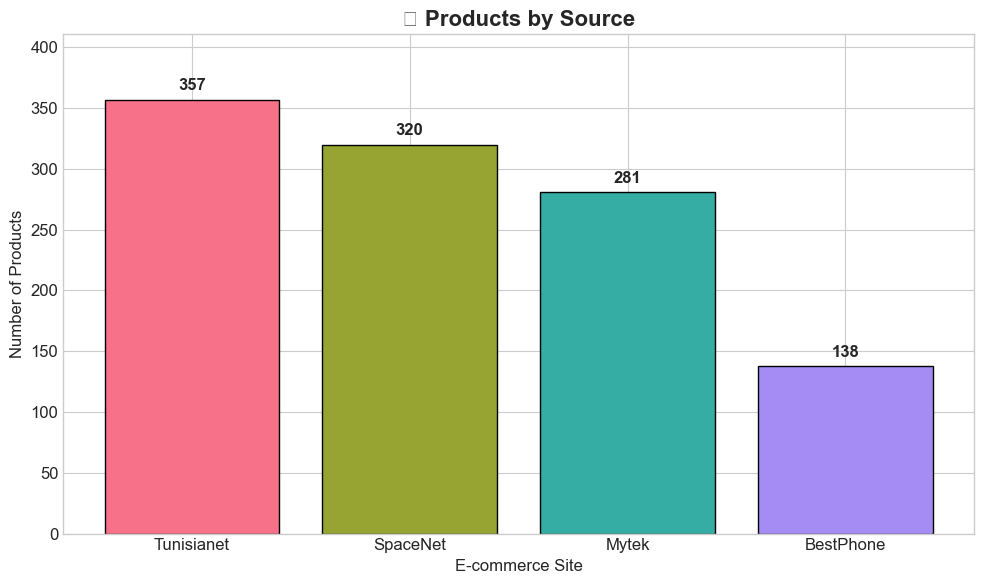

In [24]:
# Products by source
fig, ax = plt.subplots(figsize=(10, 6))

source_counts = df['source'].value_counts()
colors = sns.color_palette('husl', len(source_counts))

bars = ax.bar(source_counts.index, source_counts.values, color=colors, edgecolor='black')

# Add value labels on bars
for bar, value in zip(bars, source_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_title('📦 Products by Source', fontsize=16, fontweight='bold')
ax.set_xlabel('E-commerce Site', fontsize=12)
ax.set_ylabel('Number of Products', fontsize=12)
ax.set_ylim(0, max(source_counts.values) * 1.15)

plt.tight_layout()
plt.show()

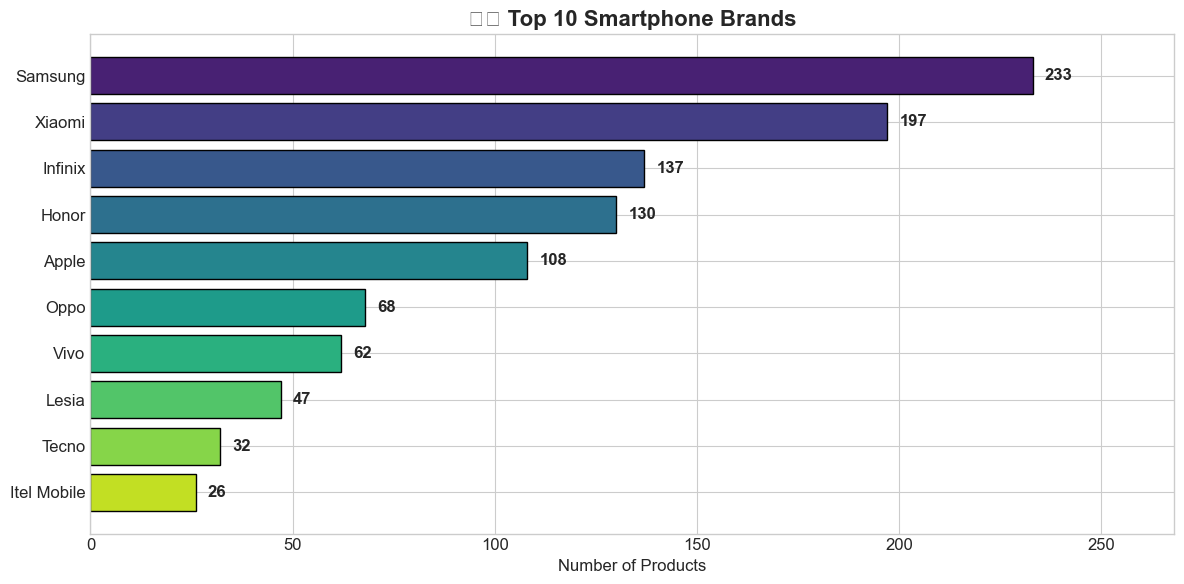

In [25]:
# Top 10 brands
fig, ax = plt.subplots(figsize=(12, 6))

brand_counts = df['brand'].value_counts().head(10)
colors = sns.color_palette('viridis', len(brand_counts))

bars = ax.barh(brand_counts.index[::-1], brand_counts.values[::-1], color=colors[::-1], edgecolor='black')

# Add value labels
for bar, value in zip(bars, brand_counts.values[::-1]):
    ax.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2, 
            f'{value}', ha='left', va='center', fontweight='bold')

ax.set_title('🏷️ Top 10 Smartphone Brands', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Products', fontsize=12)
ax.set_xlim(0, max(brand_counts.values) * 1.15)

plt.tight_layout()
plt.show()

## 6. Price Analysis

In [26]:
# Filter valid prices
df_valid_price = df[df['price'].notna() & (df['price'] > 0)].copy()

print('💰 PRICE STATISTICS (in TND)')
print('=' * 40)
print(f'  Products with valid price: {len(df_valid_price)}/{len(df)} ({len(df_valid_price)/len(df)*100:.1f}%)')
print(f'  Min price: {df_valid_price["price"].min():.0f} TND')
print(f'  Max price: {df_valid_price["price"].max():.0f} TND')
print(f'  Mean price: {df_valid_price["price"].mean():.0f} TND')
print(f'  Median price: {df_valid_price["price"].median():.0f} TND')
print(f'  Std deviation: {df_valid_price["price"].std():.0f} TND')

💰 PRICE STATISTICS (in TND)
  Products with valid price: 953/1096 (87.0%)
  Min price: 1 TND
  Max price: 8899 TND
  Mean price: 795 TND
  Median price: 499 TND
  Std deviation: 1196 TND


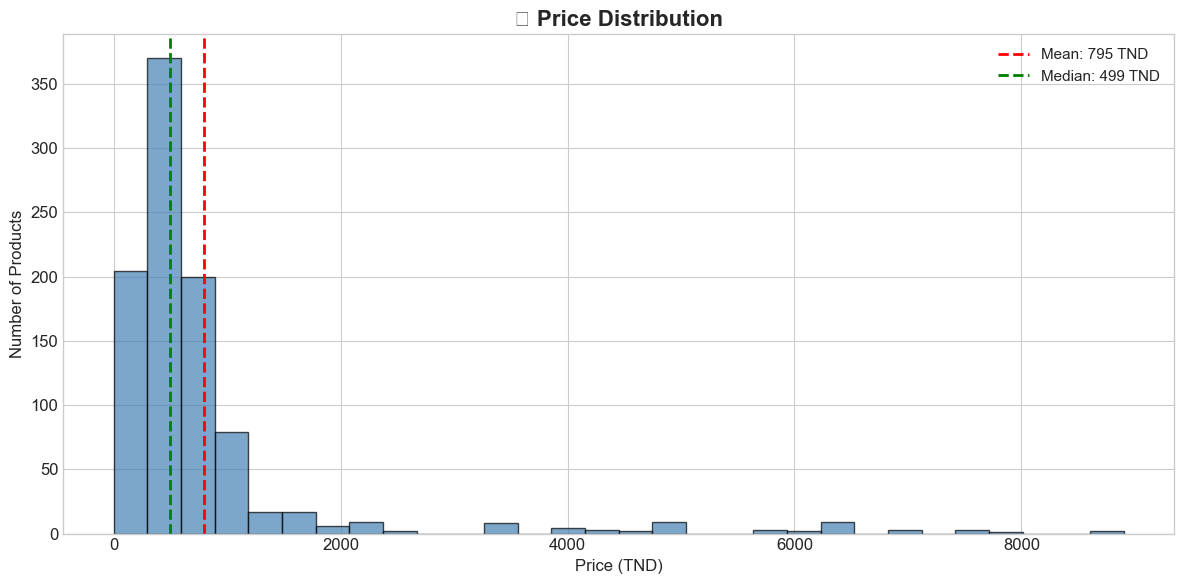

In [27]:
# Price distribution histogram
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df_valid_price['price'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(df_valid_price['price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_valid_price["price"].mean():.0f} TND')
ax.axvline(df_valid_price['price'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_valid_price["price"].median():.0f} TND')

ax.set_title('💰 Price Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Price (TND)', fontsize=12)
ax.set_ylabel('Number of Products', fontsize=12)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

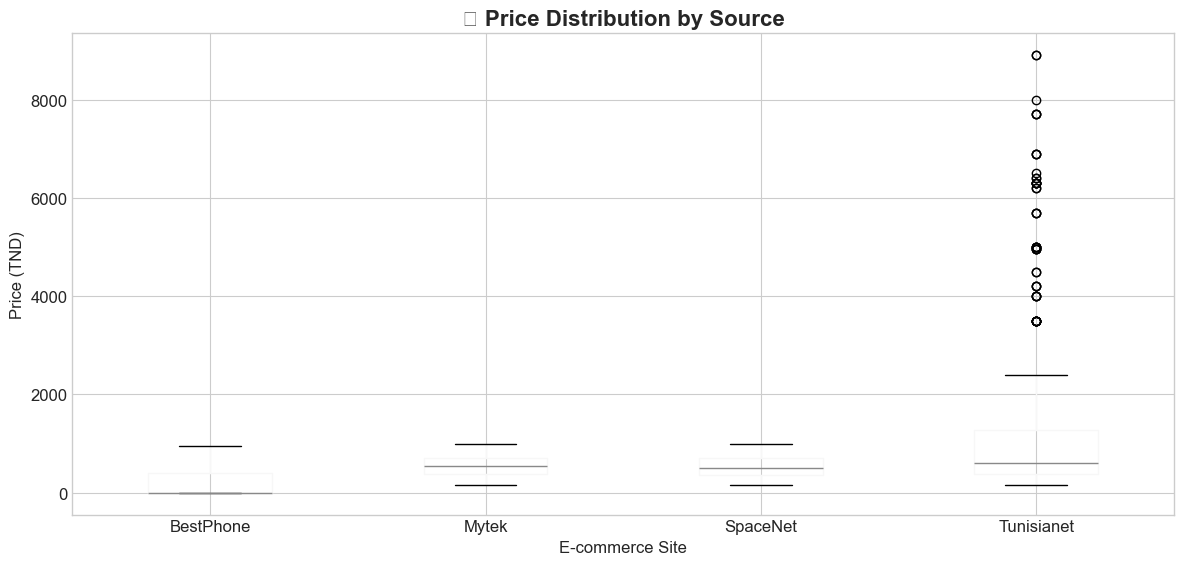

In [28]:
# Price by source (boxplot)
fig, ax = plt.subplots(figsize=(12, 6))

df_valid_price.boxplot(column='price', by='source', ax=ax)

ax.set_title('💰 Price Distribution by Source', fontsize=16, fontweight='bold')
ax.set_xlabel('E-commerce Site', fontsize=12)
ax.set_ylabel('Price (TND)', fontsize=12)
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

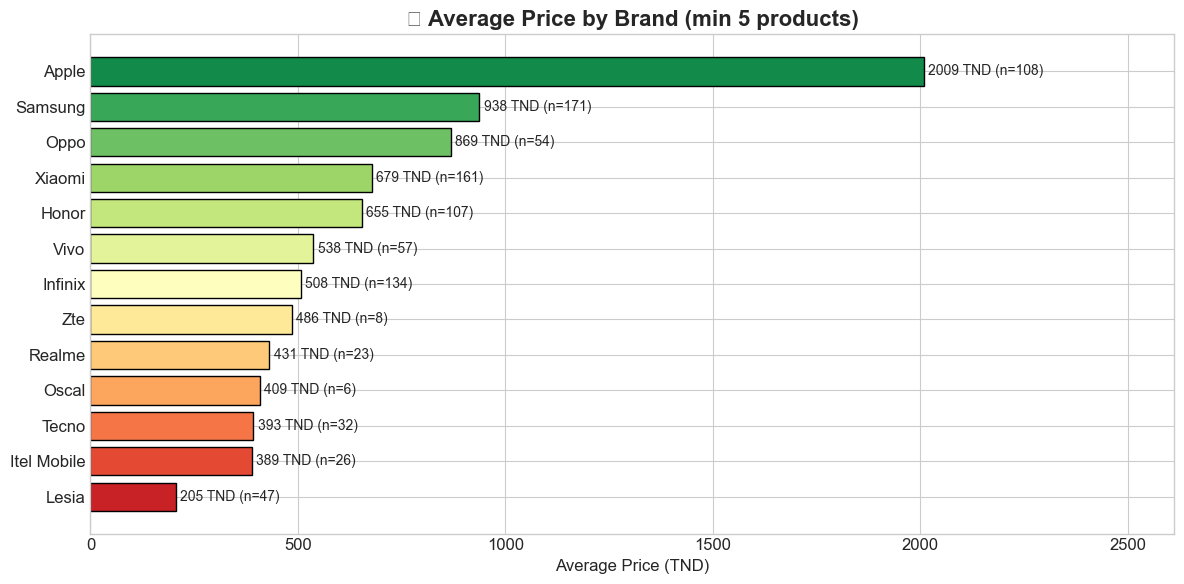

In [29]:
# Average price by brand
fig, ax = plt.subplots(figsize=(12, 6))

brand_prices = df_valid_price.groupby('brand')['price'].agg(['mean', 'count'])
brand_prices = brand_prices[brand_prices['count'] >= 5]  # At least 5 products
brand_prices = brand_prices.sort_values('mean', ascending=True)

colors = sns.color_palette('RdYlGn', len(brand_prices))
bars = ax.barh(brand_prices.index, brand_prices['mean'], color=colors, edgecolor='black')

# Add value labels
for bar, (_, row) in zip(bars, brand_prices.iterrows()):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
            f'{row["mean"]:.0f} TND (n={int(row["count"])})', ha='left', va='center', fontsize=10)

ax.set_title('💰 Average Price by Brand (min 5 products)', fontsize=16, fontweight='bold')
ax.set_xlabel('Average Price (TND)', fontsize=12)
ax.set_xlim(0, brand_prices['mean'].max() * 1.3)

plt.tight_layout()
plt.show()

## 7. Specifications Analysis

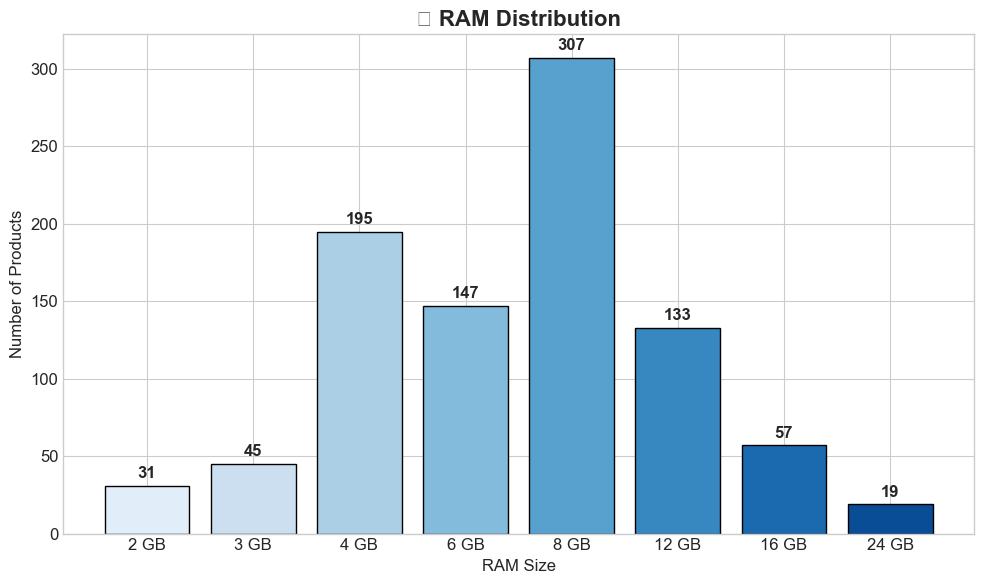

In [30]:
# RAM Distribution
fig, ax = plt.subplots(figsize=(10, 6))

ram_counts = df['ram_gb'].value_counts().sort_index()
# Filter to common RAM values
ram_counts = ram_counts[ram_counts.index.isin([2, 3, 4, 6, 8, 12, 16, 24])]

colors = sns.color_palette('Blues', len(ram_counts))
bars = ax.bar([f'{int(x)} GB' for x in ram_counts.index], ram_counts.values, color=colors, edgecolor='black')

for bar, value in zip(bars, ram_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax.set_title('📱 RAM Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('RAM Size', fontsize=12)
ax.set_ylabel('Number of Products', fontsize=12)

plt.tight_layout()
plt.show()

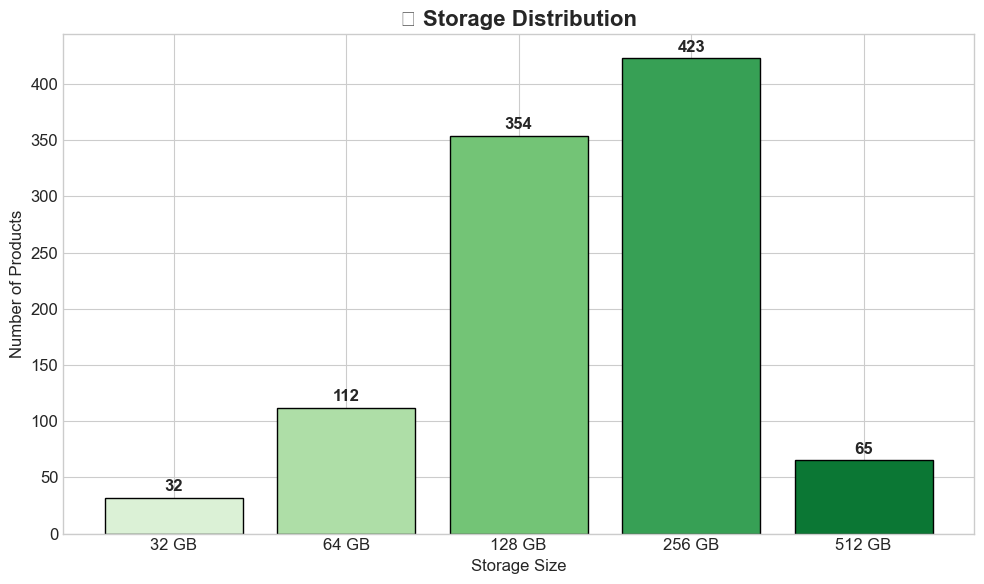

In [31]:
# Storage Distribution
fig, ax = plt.subplots(figsize=(10, 6))

storage_counts = df['storage_gb'].value_counts().sort_index()
# Filter to common storage values
storage_counts = storage_counts[storage_counts.index.isin([32, 64, 128, 256, 512, 1024])]

colors = sns.color_palette('Greens', len(storage_counts))
labels = [f'{int(x)} GB' if x < 1024 else '1 TB' for x in storage_counts.index]
bars = ax.bar(labels, storage_counts.values, color=colors, edgecolor='black')

for bar, value in zip(bars, storage_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax.set_title('💾 Storage Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Storage Size', fontsize=12)
ax.set_ylabel('Number of Products', fontsize=12)

plt.tight_layout()
plt.show()

🔋 BATTERY STATISTICS
  Products with battery info: 983/1096
  Min: 2500 mAh
  Max: 8300 mAh
  Mean: 5084 mAh
  Most common: 5000 mAh


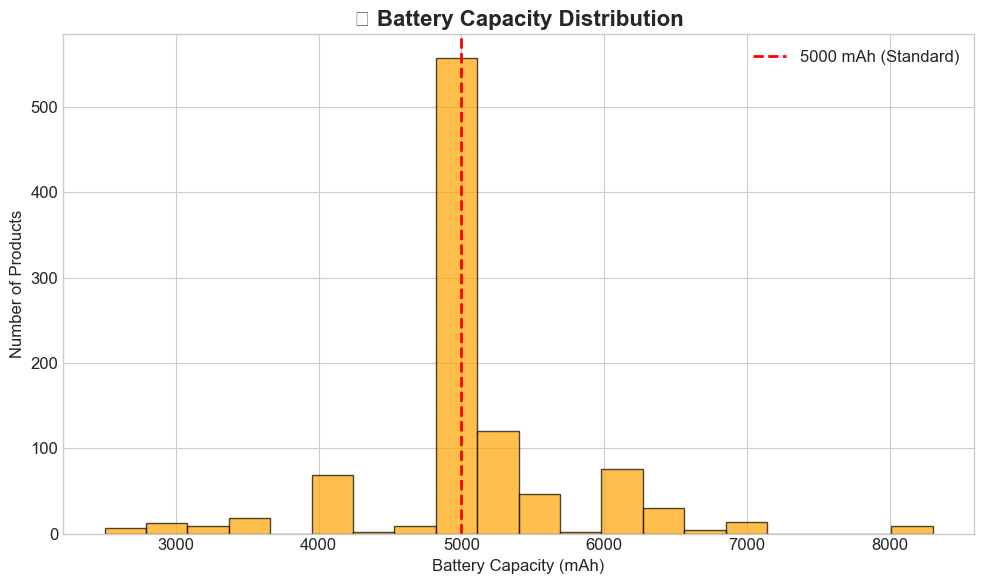

In [32]:
# Battery Analysis
df_valid_battery = df[df['battery_mah'].notna() & (df['battery_mah'] > 0)]

print('🔋 BATTERY STATISTICS')
print('=' * 40)
print(f'  Products with battery info: {len(df_valid_battery)}/{len(df)}')
print(f'  Min: {df_valid_battery["battery_mah"].min():.0f} mAh')
print(f'  Max: {df_valid_battery["battery_mah"].max():.0f} mAh')
print(f'  Mean: {df_valid_battery["battery_mah"].mean():.0f} mAh')
print(f'  Most common: {df_valid_battery["battery_mah"].mode().iloc[0]:.0f} mAh')

# Battery histogram
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_valid_battery['battery_mah'], bins=20, color='orange', edgecolor='black', alpha=0.7)
ax.axvline(5000, color='red', linestyle='--', linewidth=2, label='5000 mAh (Standard)')

ax.set_title('🔋 Battery Capacity Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Battery Capacity (mAh)', fontsize=12)
ax.set_ylabel('Number of Products', fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

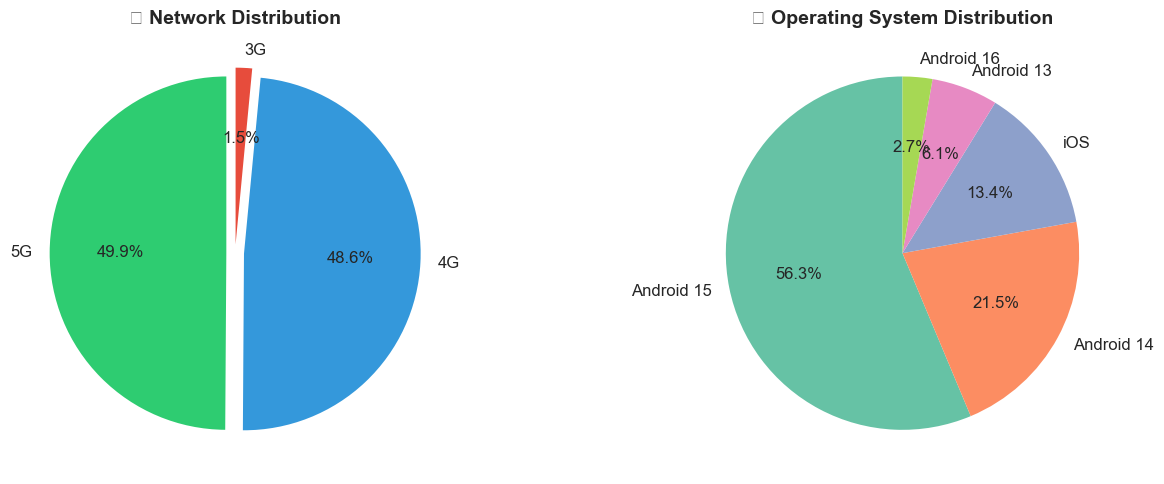

In [33]:
# Network Distribution (5G vs 4G)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Network pie chart
network_counts = df['network'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c']
axes[0].pie(network_counts.values, labels=network_counts.index, autopct='%1.1f%%', 
            colors=colors[:len(network_counts)], startangle=90, explode=[0.05]*len(network_counts))
axes[0].set_title('📶 Network Distribution', fontsize=14, fontweight='bold')

# OS distribution
os_counts = df['os'].value_counts().head(5)
colors = sns.color_palette('Set2', len(os_counts))
axes[1].pie(os_counts.values, labels=os_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('📱 Operating System Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Missing Values Analysis

In [34]:
# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing': [df[col].isna().sum() + (df[col].astype(str).str.strip() == '').sum() for col in df.columns],
    'Total': len(df)
})
missing_data['Percentage'] = (missing_data['Missing'] / missing_data['Total'] * 100).round(1)
missing_data['Available'] = 100 - missing_data['Percentage']
missing_data = missing_data.sort_values('Percentage', ascending=False)

print('❓ MISSING VALUES ANALYSIS')
print('=' * 60)
for _, row in missing_data.iterrows():
    status = '✓' if row['Percentage'] < 20 else '⚠️' if row['Percentage'] < 50 else '❌'
    print(f"  {status} {row['Column']}: {row['Missing']} missing ({row['Percentage']}%)")

❓ MISSING VALUES ANALYSIS
  ⚠️ camera_front_mp: 493 missing (45.0%)
  ⚠️ screen_inches: 479 missing (43.7%)
  ⚠️ camera_rear_mp: 376 missing (34.3%)
  ⚠️ os: 274 missing (25.0%)
  ✓ price: 143 missing (13.0%)
  ✓ processor_type: 123 missing (11.2%)
  ✓ ram_gb: 121 missing (11.0%)
  ✓ battery_mah: 111 missing (10.1%)
  ✓ network: 98 missing (8.9%)
  ✓ storage_gb: 33 missing (3.0%)
  ✓ brand: 6 missing (0.5%)
  ✓ name: 0 missing (0.0%)
  ✓ url: 0 missing (0.0%)
  ✓ source: 0 missing (0.0%)


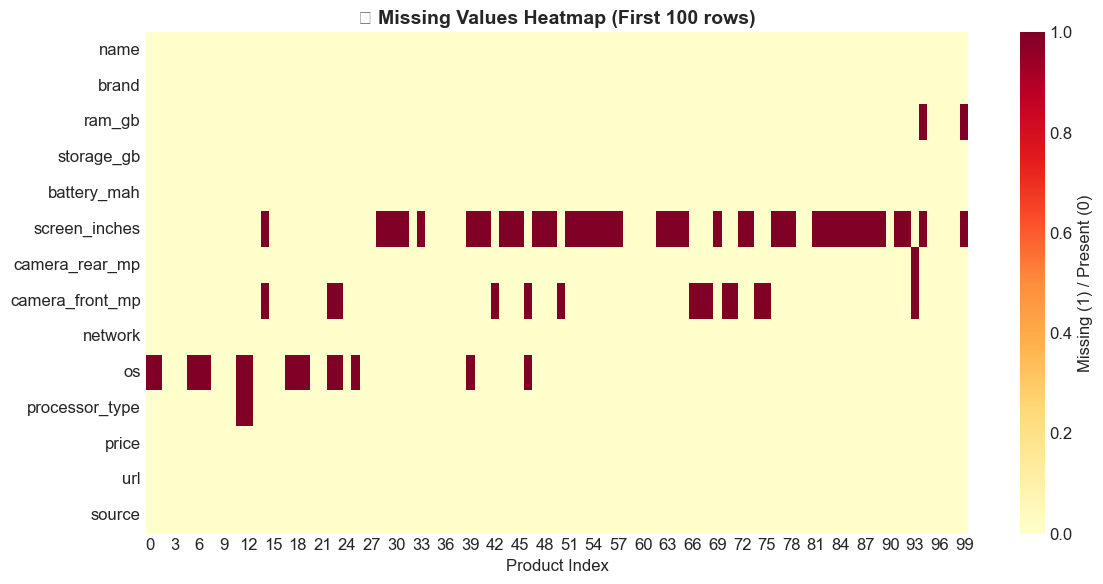

In [35]:
# Missing values heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Create a matrix of missing values
missing_matrix = df.isnull().astype(int)

# Plot heatmap for sample
sns.heatmap(missing_matrix.head(100).T, cmap='YlOrRd', cbar_kws={'label': 'Missing (1) / Present (0)'},
            yticklabels=df.columns, ax=ax)

ax.set_title('❓ Missing Values Heatmap (First 100 rows)', fontsize=14, fontweight='bold')
ax.set_xlabel('Product Index', fontsize=12)

plt.tight_layout()
plt.show()

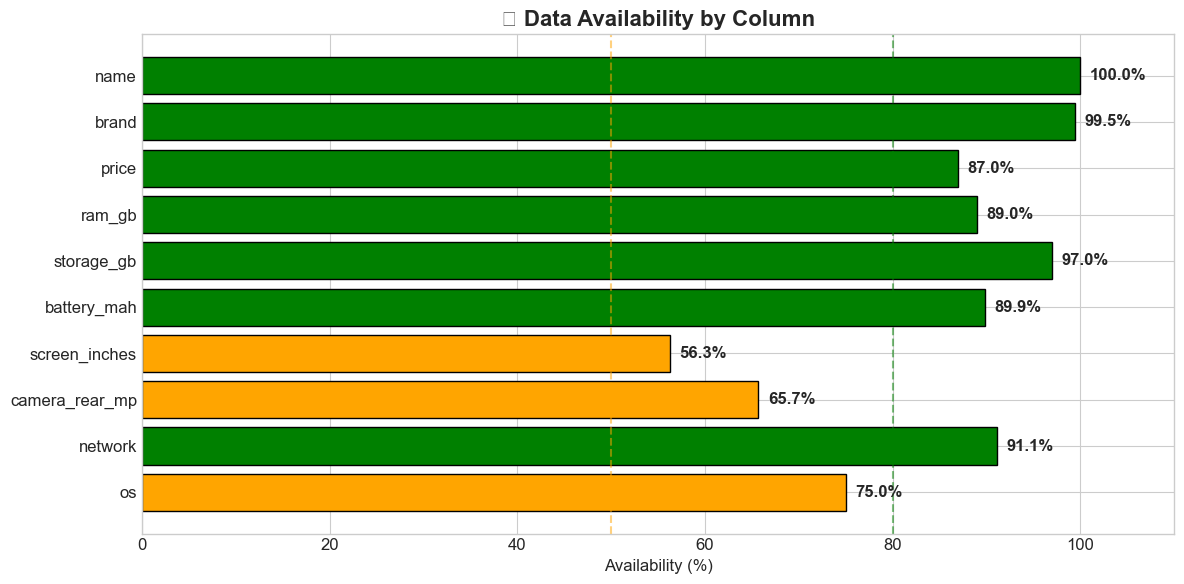

In [36]:
# Data availability bar chart
fig, ax = plt.subplots(figsize=(12, 6))

cols_to_show = ['name', 'brand', 'price', 'ram_gb', 'storage_gb', 'battery_mah', 
                'screen_inches', 'camera_rear_mp', 'network', 'os']
availability = [100 - missing_data[missing_data['Column'] == col]['Percentage'].values[0] for col in cols_to_show]

colors = ['green' if a >= 80 else 'orange' if a >= 50 else 'red' for a in availability]
bars = ax.barh(cols_to_show[::-1], availability[::-1], color=colors[::-1], edgecolor='black')

# Add percentage labels
for bar, value in zip(bars, availability[::-1]):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{value:.1f}%', ha='left', va='center', fontweight='bold')

ax.set_title('📊 Data Availability by Column', fontsize=16, fontweight='bold')
ax.set_xlabel('Availability (%)', fontsize=12)
ax.set_xlim(0, 110)
ax.axvline(80, color='green', linestyle='--', alpha=0.5, label='Good (80%)')
ax.axvline(50, color='orange', linestyle='--', alpha=0.5, label='Warning (50%)')

plt.tight_layout()
plt.show()

## 9. Data Quality Summary

In [37]:
# Calculate quality scores
critical_cols = ['name', 'brand', 'price', 'ram_gb', 'storage_gb', 'battery_mah']
quality_scores = {}

for col in critical_cols:
    valid = df[col].notna() & (df[col].astype(str).str.strip() != '')
    quality_scores[col] = valid.sum() / len(df) * 100

avg_quality = np.mean(list(quality_scores.values()))

print('📊 DATA QUALITY SCORES (Critical Fields)')
print('=' * 50)
for col, score in quality_scores.items():
    status = '✓' if score >= 80 else '⚠️' if score >= 50 else '❌'
    bar = '█' * int(score // 5) + '░' * (20 - int(score // 5))
    print(f'  {status} {col:15s} [{bar}] {score:.1f}%')

print('=' * 50)
print(f'  📈 OVERALL QUALITY SCORE: {avg_quality:.1f}%')

📊 DATA QUALITY SCORES (Critical Fields)
  ✓ name            [████████████████████] 100.0%
  ✓ brand           [███████████████████░] 99.5%
  ✓ price           [█████████████████░░░] 87.0%
  ✓ ram_gb          [█████████████████░░░] 89.0%
  ✓ storage_gb      [███████████████████░] 97.0%
  ✓ battery_mah     [█████████████████░░░] 89.9%
  📈 OVERALL QUALITY SCORE: 93.7%


## 10. Key Insights & Conclusions

### 📌 Key Findings

#### 1. Dataset Size
- **1,096 smartphone listings** from 4 Tunisian e-commerce sites
- Tunisianet has the largest inventory (357 products)
- Good diversity across sources for price comparison

#### 2. Brand Distribution
- **Samsung and Xiaomi** dominate the Tunisian market
- **Apple (iPhone)** present across all stores
- Budget brands available: Infinix, Honor, Tecno, Itel

#### 3. Price Insights
- Wide price range: ~159 TND (budget) to 999+ TND (flagship)
- Average smartphone price: ~500 TND
- **Same phone appears at different prices across stores** → opportunity for price comparison

#### 4. Specifications Trends
- Most common RAM: **8 GB** (28% of products)
- Most common storage: **128 GB**
- Standard battery: **5000 mAh**
- **5G adoption increasing** (45% of products)

#### 5. Data Quality
- Overall quality score: **~92%**
- Good coverage: name, brand, RAM, storage
- Areas to improve: screen size, camera specs

---

### 🎯 Recommendations for the System

1. **Price Comparison Feature**: Same phone is listed at different prices across stores - highlight savings
2. **Budget-Based Filtering**: Wide price range allows for budget categories
3. **Spec-Based Matching**: Good RAM/storage data enables accurate recommendations
4. **Store Availability**: Keep source column to show where to buy

---

### ✅ Week 1 Complete!

**Next Steps (Week 2):**
- Data preprocessing and feature engineering
- Handle outliers and normalize values
- Create derived features for recommendation algorithm